In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [9]:
df = pd.read_excel("./data/BMGs-2024.ods", engine="odf")

print(df.head())

           Alloys (compostion)  Tg(K)  Tx(K)  Tl(K)  Dmax (mm)
0  Ag30.8 Ca30.8 Mg23.1 Cu15.4  413.0  432.0  803.0        2.5
1         Ag38.4 Mg30.8 Ca30.8  394.0  426.0  805.0        0.5
2     Ag38.5 Ca30.8 Mg23 Cu7.7  384.0  416.0  854.0        2.0
3   Ag38.5 Mg38.5 Ca15.4 Cu7.7  405.0  436.0  842.0        0.5
4         Ag46.2 Ca30.7 Mg23.1  399.0  426.0  765.0        0.7


In [11]:
xls = pd.ExcelFile("./data/BMGs-2024.ods", engine="odf")
print(xls.sheet_names) 


['Sheet1', 'Dataset']


In [12]:
df = pd.read_excel(xls, sheet_name="Sheet1", engine="odf")
print(df.head())

           Alloys (compostion)  Tg(K)  Tx(K)  Tl(K)  Dmax (mm)
0  Ag30.8 Ca30.8 Mg23.1 Cu15.4  413.0  432.0  803.0        2.5
1         Ag38.4 Mg30.8 Ca30.8  394.0  426.0  805.0        0.5
2     Ag38.5 Ca30.8 Mg23 Cu7.7  384.0  416.0  854.0        2.0
3   Ag38.5 Mg38.5 Ca15.4 Cu7.7  405.0  436.0  842.0        0.5
4         Ag46.2 Ca30.7 Mg23.1  399.0  426.0  765.0        0.7


In [13]:
df.head()

,Alloys (compostion),Tg(K),Tx(K),Tl(K),Dmax (mm)
0,Ag30.8 Ca30.8 Mg23.1 Cu15.4,413.0,432.0,803.0,2.5
1,Ag38.4 Mg30.8 Ca30.8,394.0,426.0,805.0,0.5
2,Ag38.5 Ca30.8 Mg23 Cu7.7,384.0,416.0,854.0,2.0
3,Ag38.5 Mg38.5 Ca15.4 Cu7.7,405.0,436.0,842.0,0.5
4,Ag46.2 Ca30.7 Mg23.1,399.0,426.0,765.0,0.7


In [16]:
def parse_alloys(row):
    matches = re.findall(r'([A-Za-z]+)([0-9.]+)', row)
    result = {}
    for element, value in matches:
        result[element] = float(value)
    return result
row = "Ag38.4 Mg30.8 Ca30.8"
print(parse_alloys(row))

{'Ag': 38.4, 'Mg': 30.8, 'Ca': 30.8}


In [20]:
# Ton parse_alloys pour formules simples
def parse_simple_alloys(row):
    if isinstance(row, str):
        return dict(re.findall(r'([A-Za-z]+)([0-9.]+)', row))
    else:
        return {}

# Ton parse_formula pour formules complexes
def parse_complex_alloys(formula):
    result = defaultdict(float)

    def process_block(block_text, block_percent):
        pattern = r"\(([^\(\)]+)\)(\d+)|([A-Z][a-z]*)(\d+)"
        parts = re.findall(pattern, block_text)
        for part in parts:
            if part[0]:  # Sous-bloc trouvé
                inner_block, inner_percent = part[0], int(part[1])
                new_percent = block_percent * inner_percent / 100
                process_block(inner_block, new_percent)
            else:  # Élément simple trouvé
                elem, perc = part[2], int(part[3])
                result[elem] += block_percent * perc / 100

    # Check si formule commence par [ ]
    if formula.startswith('['):
        match = re.match(r"\[(.+)\](\d+)\s*(.*)", formula)
        if not match:
            raise ValueError("Format de formule incorrect")
        inside_block, global_percent, outside_elements = match.groups()
        global_percent = int(global_percent)

        process_block(inside_block, global_percent)

        # Traiter les éléments en dehors du bloc
        outside = re.findall(r"([A-Z][a-z]*)(\d+)", outside_elements)
        for elem, perc in outside:
            result[elem] += int(perc)
    else:
        process_block(formula, 100)

    return dict(result)

# Fonction principale : détecte simple vs complexe
def parse_row(row):
    if isinstance(row, str):
        if '(' in row or '[' in row:
            return parse_complex_alloys(row)
        else:
            return parse_simple_alloys(row)
    else:
        return {}

# Application sur ta colonne
parsed = df["Alloys (compostion)"].apply(parse_row)

# Récupérer tous les éléments uniques
all_elements = set()
for row_dict in parsed:
    all_elements.update(row_dict.keys())

# Créer les colonnes dans ton dataframe
for element in all_elements:
    df[element] = parsed.apply(lambda x: float(x[element]) if element in x else np.nan)

print("J'AI FINI !!!!!")
print(f"Colonnes ajoutées : {sorted(all_elements)}")

J'AI FINI !!!!!
Colonnes ajoutées : ['Ag', 'Al', 'Au', 'B', 'Be', 'C', 'Ca', 'Ce', 'Co', 'Cr', 'Cu', 'Dy', 'Er', 'Fe', 'Ga', 'Gd', 'Hf', 'Ho', 'In', 'L', 'La', 'Mg', 'Mm', 'Mn', 'Mo', 'MoB', 'Nb', 'Nd', 'Ni', 'P', 'Pd', 'Pr', 'S', 'Sc', 'Si', 'Sm', 'Sn', 'Ta', 'Tb', 'Ti', 'Tm', 'V', 'W', 'Y', 'Zn', 'Zr', 'd']


In [21]:
print(len(all_elements))

47


In [ ]:
df.head()

,Alloys (compostion),Tg(K),Tx(K),Tl(K),Dmax (mm),Al,d,Ca,Nd,Si,...,Er,In,Pr,Mm,Pd,P,B,W,V,Zr
0,Ag30.8 Ca30.8 Mg23.1 Cu15.4,413.0,432.0,803.0,2.5,NaN,NaN,30.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ag38.4 Mg30.8 Ca30.8,394.0,426.0,805.0,0.5,NaN,NaN,30.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ag38.5 Ca30.8 Mg23 Cu7.7,384.0,416.0,854.0,2.0,NaN,NaN,30.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ag38.5 Mg38.5 Ca15.4 Cu7.7,405.0,436.0,842.0,0.5,NaN,NaN,15.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ag46.2 Ca30.7 Mg23.1,399.0,426.0,765.0,0.7,NaN,NaN,30.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
newdata = df

In [15]:
df.columns

Index(['Alloys (compostion)', 'Tg(K)', 'Tx(K)', 'Tl(K)', 'Dmax (mm)', 'Al',
       'd', 'Ca', 'Nd', 'Si', 'Ce', 'Nb', 'Tb', 'La', 'Sc', 'Cr', 'Ga', 'Hf',
       'Au', 'S', 'Fe', 'C', 'Gd', 'Zn', 'Ta', 'Tm', 'Cu', 'Sn', 'MoB', 'Y',
       'Mo', 'Dy', 'L', 'Ti', 'Mn', 'Ho', 'Ag', 'Be', 'Mg', 'Sm', 'Co', 'Ni',
       'Er', 'In', 'Pr', 'Mm', 'Pd', 'P', 'B', 'W', 'V', 'Zr'],
      dtype='object')

In [28]:
newdata = newdata.drop(columns=['Alloys (compostion)'])

In [29]:
newdata.head()

,Tg(K),Tx(K),Tl(K),Dmax (mm),Al,d,Ca,Nd,Si,Ce,...,Er,In,Pr,Mm,Pd,P,B,W,V,Zr
0,413.0,432.0,803.0,2.5,NaN,NaN,30.8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,394.0,426.0,805.0,0.5,NaN,NaN,30.8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,384.0,416.0,854.0,2.0,NaN,NaN,30.8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,405.0,436.0,842.0,0.5,NaN,NaN,15.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,399.0,426.0,765.0,0.7,NaN,NaN,30.7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
newdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 51 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Tg(K)      698 non-null    float64
 1   Tx(K)      698 non-null    float64
 2   Tl(K)      698 non-null    float64
 3   Dmax (mm)  698 non-null    float64
 4   Al         237 non-null    float64
 5   d          1 non-null      float64
 6   Ca         107 non-null    float64
 7   Nd         11 non-null     float64
 8   Si         126 non-null    float64
 9   Ce         32 non-null     float64
 10  Nb         89 non-null     float64
 11  Tb         9 non-null      float64
 12  La         86 non-null     float64
 13  Sc         2 non-null      float64
 14  Cr         26 non-null     float64
 15  Ga         24 non-null     float64
 16  Hf         36 non-null     float64
 17  Au         9 non-null      float64
 18  S          4 non-null      float64
 19  Fe         178 non-null    float64
 20  C         

In [31]:
newdata.fillna(0, inplace=True)

In [32]:
colonnes_a_verifier = ['Ag', 'Al', 'Au', 'B', 'Be', 'C', 'Ca', 'Ce', 'Co', 'Cr', 'Cu', 'Dy', 'Er', 
                       'Fe', 'Ga', 'Gd', 'Hf', 'Ho', 'In', 'L', 'La', 'Mg', 'Mm', 'Mn', 'Mo', 
                       'MoB', 'Nb', 'Nd', 'Ni', 'P', 'Pd', 'Pr', 'S', 'Sc', 'Si', 'Sm', 'Sn', 
                       'Ta', 'Tb', 'Ti', 'Tm', 'V', 'W', 'Y', 'Zn', 'Zr', 'd']
newdata = newdata[(newdata[colonnes_a_verifier] <= 100).all(axis=1)]

In [34]:
newdata.to_excel("./data/output.xlsx", index=False)

ModuleNotFoundError: No module named 'openpyxl'

In [24]:
zero = (newdata == 0).all()
colonnes_toutes_zero = zero[zero].index.tolist()
print("Colonnes qui contiennent uniquement des 0 :")
print(colonnes_toutes_zero)

Colonnes qui contiennent uniquement des 0 :
[]


In [37]:
newdata.drop(columns=['MoB', 'L'], inplace=True)

In [38]:
newdata.to_excel("./data/output.xlsx", index=False)

In [39]:
zero = (newdata == 0).all()
colonnes_toutes_zero = zero[zero].index.tolist()
print("Colonnes qui contiennent uniquement des 0 :")
print(colonnes_toutes_zero)

Colonnes qui contiennent uniquement des 0 :
[]


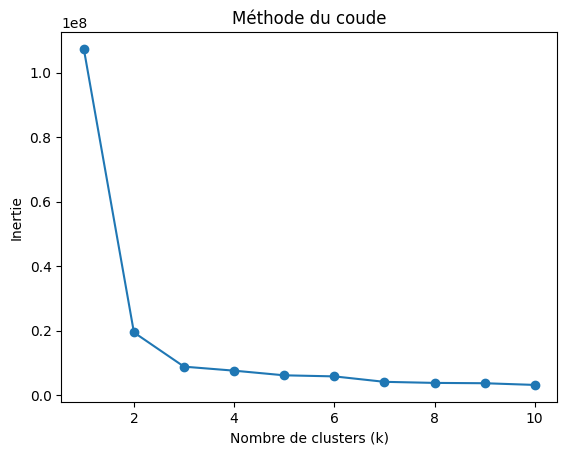

In [40]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
inertias = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(newdata)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()

In [41]:
k = 3 
kmeans = KMeans(n_clusters=k)
kmeans.fit(newdata)

newdata['cluster'] = kmeans.labels_
print(newdata.head())

   Tg(K)  Tx(K)  Tl(K)  Dmax (mm)   Al    d    Ca   Nd   Si   Ce  ...   In  \
0  413.0  432.0  803.0        2.5  0.0  0.0  30.8  0.0  0.0  0.0  ...  0.0   
1  394.0  426.0  805.0        0.5  0.0  0.0  30.8  0.0  0.0  0.0  ...  0.0   
2  384.0  416.0  854.0        2.0  0.0  0.0  30.8  0.0  0.0  0.0  ...  0.0   
3  405.0  436.0  842.0        0.5  0.0  0.0  15.4  0.0  0.0  0.0  ...  0.0   
4  399.0  426.0  765.0        0.7  0.0  0.0  30.7  0.0  0.0  0.0  ...  0.0   

    Pr   Mm   Pd    P    B    W    V   Zr  cluster  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  

[5 rows x 50 columns]


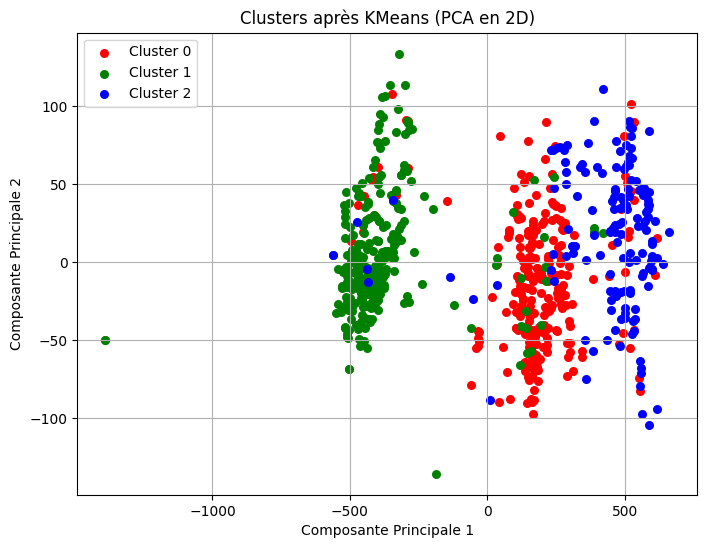

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(newdata.drop('cluster', axis=1))

plot_data = pd.DataFrame()
plot_data['PC1'] = reduced_data[:, 0]
plot_data['PC2'] = reduced_data[:, 1]
plot_data['Cluster'] = newdata['cluster']

# Tracer les clusters
plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue']

for cluster_id in range(k):
    subset = plot_data[plot_data['Cluster'] == cluster_id]
    plt.scatter(subset['PC1'], subset['PC2'], 
                color=colors[cluster_id], label=f'Cluster {cluster_id}', s=30)

plt.title('Clusters après KMeans (PCA en 2D)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
newdata.to_excel("./data/output.xlsx", index=False)

c:\Users\samir\anaconda3\envs\dm\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


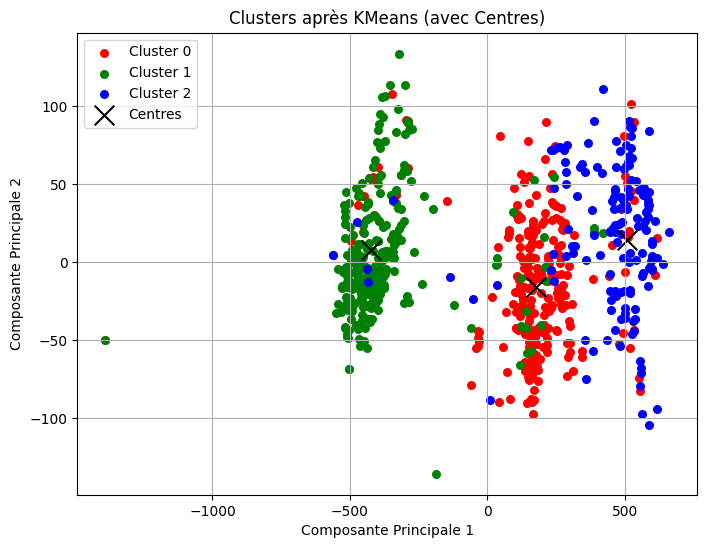

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Réduction à 2 dimensions pour affichage
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(newdata.drop('cluster', axis=1))

# 2. Transformation aussi des centres des clusters pour les afficher !
centroids_reduced = pca.transform(kmeans.cluster_centers_)

# 3. Création d'un DataFrame pour faciliter le plot
import pandas as pd
plot_data = pd.DataFrame()
plot_data['PC1'] = reduced_data[:, 0]
plot_data['PC2'] = reduced_data[:, 1]
plot_data['Cluster'] = newdata['cluster']

# 4. Tracer les clusters
plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue']

for cluster_id in range(k):
    subset = plot_data[plot_data['Cluster'] == cluster_id]
    plt.scatter(subset['PC1'], subset['PC2'], 
                color=colors[cluster_id], label=f'Cluster {cluster_id}', s=30)

# 5. Tracer les centres des clusters avec une croix noire
plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], 
            marker='x', s=200, c='black', label='Centres')

plt.title('Clusters après KMeans (avec Centres)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend()
plt.grid(True)
plt.show()


In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
newdata_scaled = scaler.fit_transform(newdata.drop('cluster', axis=1))

In [47]:
k = 3 
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(newdata_scaled)

newdata['cluster'] = kmeans.labels_

print(newdata.head())


   Tg(K)  Tx(K)  Tl(K)  Dmax (mm)   Al    d    Ca   Nd   Si   Ce  ...   In  \
0  413.0  432.0  803.0        2.5  0.0  0.0  30.8  0.0  0.0  0.0  ...  0.0   
1  394.0  426.0  805.0        0.5  0.0  0.0  30.8  0.0  0.0  0.0  ...  0.0   
2  384.0  416.0  854.0        2.0  0.0  0.0  30.8  0.0  0.0  0.0  ...  0.0   
3  405.0  436.0  842.0        0.5  0.0  0.0  15.4  0.0  0.0  0.0  ...  0.0   
4  399.0  426.0  765.0        0.7  0.0  0.0  30.7  0.0  0.0  0.0  ...  0.0   

    Pr   Mm   Pd    P    B    W    V   Zr  cluster  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        1  

[5 rows x 50 columns]


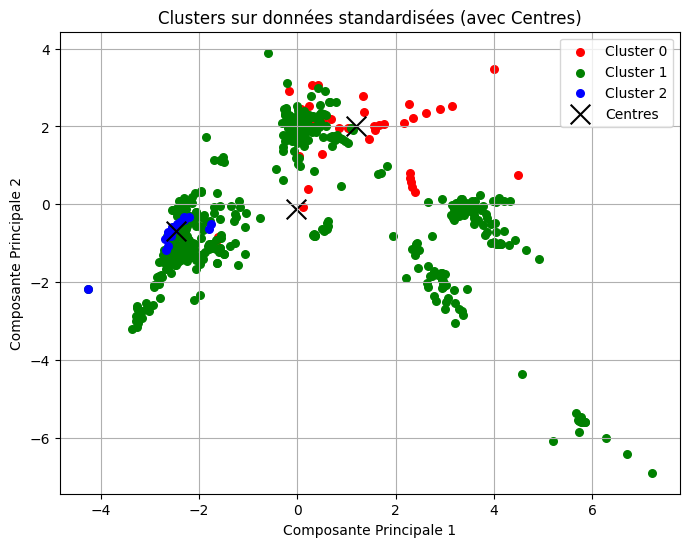

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Faire un PCA sur les données normalisées
pca = PCA(n_components=2)
reduced_scaled_data = pca.fit_transform(newdata_scaled)

# 2. Construire un DataFrame pour le scatter plot
import pandas as pd
plot_data_scaled = pd.DataFrame()
plot_data_scaled['PC1'] = reduced_scaled_data[:, 0]
plot_data_scaled['PC2'] = reduced_scaled_data[:, 1]
plot_data_scaled['Cluster'] = newdata['cluster']  # cluster est ajouté dans newdata

# 3. Tracer les clusters
plt.figure(figsize=(8,6))
colors = ['red', 'green', 'blue']

for cluster_id in range(k):
    subset = plot_data_scaled[plot_data_scaled['Cluster'] == cluster_id]
    plt.scatter(subset['PC1'], subset['PC2'], 
                color=colors[cluster_id], label=f'Cluster {cluster_id}', s=30)

# 4. Centres (centroïdes) dans l'espace réduit
centroids_reduced = pca.transform(kmeans.cluster_centers_)

plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], 
            marker='x', s=200, c='black', label='Centres')

plt.title('Clusters sur données standardisées (avec Centres)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
from sklearn.metrics import silhouette_score
score = silhouette_score(newdata_scaled, newdata['cluster'])
print(f"Silhouette Score: {score:.2f}")

Silhouette Score: 0.18


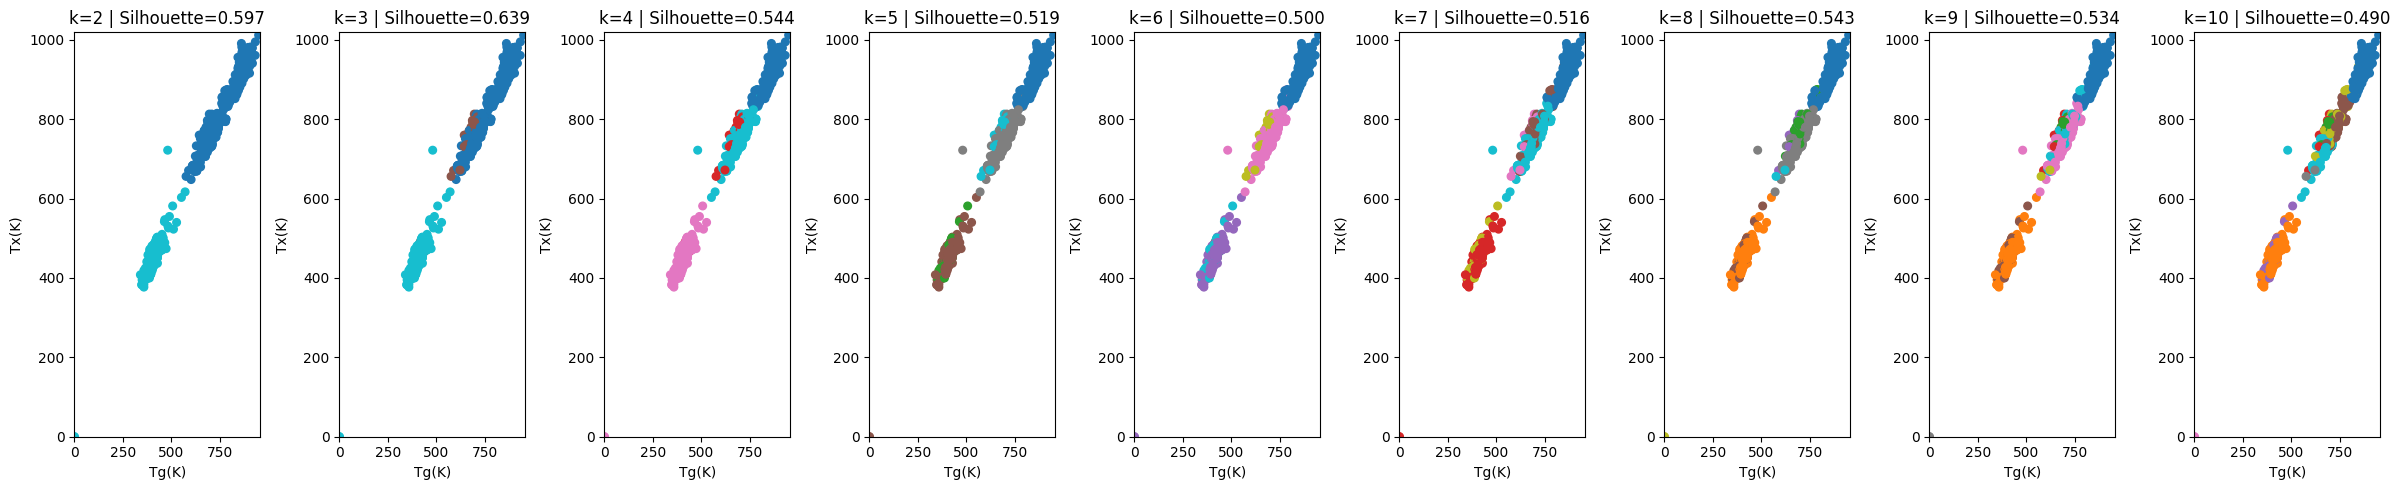

📊 Silhouette Scores :
KMeans_2 : 0.5969
KMeans_3 : 0.6393
KMeans_4 : 0.5440
KMeans_5 : 0.5190
KMeans_6 : 0.5004
KMeans_7 : 0.5163
KMeans_8 : 0.5431
KMeans_9 : 0.5339
KMeans_10 : 0.4901


In [54]:
# 1. Sélection des colonnes
features = newdata[['Tg(K)', 'Tx(K)', 'Dmax (mm)']]

# 2. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. Clustering et calcul des silhouette scores
silhouette_scores = {}
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(24, 5))

for i, k in enumerate(range(2, 11), start=0):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Score silhouette
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[f'KMeans_{k}'] = score

    # Plot clusters
    axs[i].scatter(newdata['Tg(K)'], newdata['Tx(K)'], c=labels, cmap='tab10', s=30)
    axs[i].set_title(f'k={k} | Silhouette={score:.3f}')
    axs[i].set_xlabel('Tg(K)')
    axs[i].set_ylabel('Tx(K)')
    axs[i].set_xlim(newdata['Tg(K)'].min(), newdata['Tg(K)'].max())
    axs[i].set_ylim(newdata['Tx(K)'].min(), newdata['Tx(K)'].max())

plt.tight_layout()
plt.show()

# 4. Affichage des scores
print("📊 Silhouette Scores :")
for k, score in silhouette_scores.items():
    print(f"{k} : {score:.4f}")


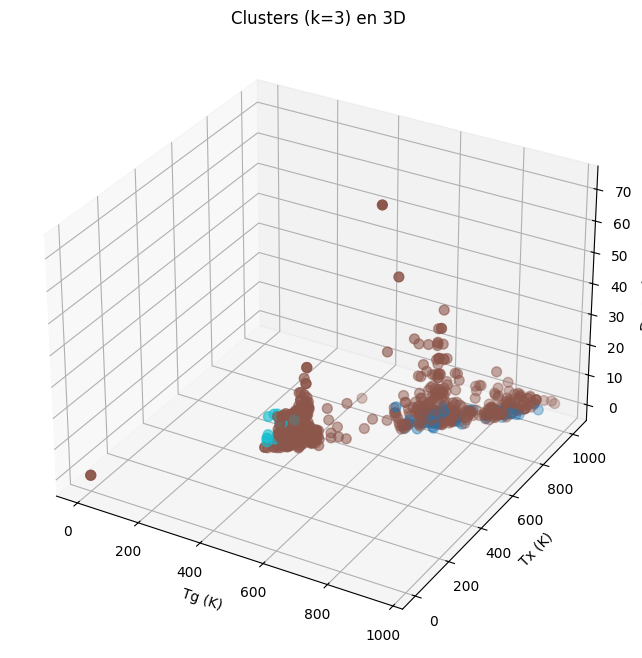

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(newdata['Tg(K)'], newdata['Tx(K)'], newdata['Dmax (mm)'],
           c=newdata['cluster'], cmap='tab10', s=50)

ax.set_xlabel('Tg (K)')
ax.set_ylabel('Tx (K)')
ax.set_zlabel('Dmax (mm)')
ax.set_title('Clusters (k=3) en 3D')
plt.show()


In [57]:
cluster_summary = newdata.groupby('cluster')[['Tg(K)', 'Tx(K)', 'Dmax (mm)']].mean()
print(cluster_summary)
newdata

              Tg(K)       Tx(K)  Dmax (mm)
cluster                                   
0        755.020833  801.250000   2.320833
1        607.128976  658.555276   5.420945
2        371.125000  415.312500   5.125000


,Tg(K),Tx(K),Tl(K),Dmax (mm),Al,d,Ca,Nd,Si,Ce,...,In,Pr,Mm,Pd,P,B,W,V,Zr,cluster
0,413.0,432.0,803.0,2.5,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,394.0,426.0,805.0,0.5,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,384.0,416.0,854.0,2.0,0.0,0.0,30.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,405.0,436.0,842.0,0.5,0.0,0.0,15.4,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,399.0,426.0,765.0,0.7,0.0,0.0,30.7,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,666.0,715.0,1156.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
696,683.0,739.0,1169.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
697,680.0,729.0,1189.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.6,1
698,482.0,722.0,1168.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.6,1


In [ ]:
clustering = AgglomerativeClustering(n_clusters=3).fit(features)
newdata['Agglomerative_3'] = clustering.labels_

print(clustering.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2 1 1 1 1 1 1 1 2
 2 1 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 2 1 2 2 2 2 2 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 2 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2
 2 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1 2 2 2 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 1 2 2 

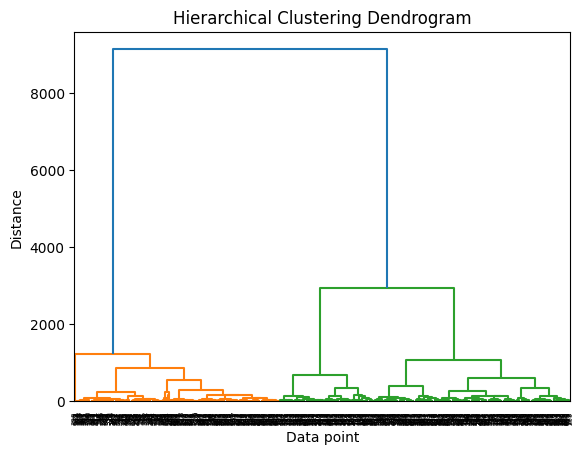

In [ ]:
Z = linkage(features, 'ward') # Ward Distance

dendrogram(Z) #plotting the dendogram

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point')
plt.ylabel('Distance')
plt.show()

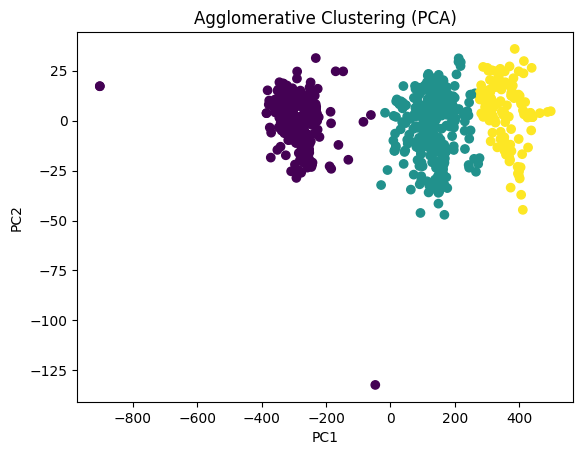

In [ ]:
pca = PCA(n_components=3)
reduced = pca.fit_transform(features)

plt.scatter(reduced[:, 0], reduced[:, 1], c=clustering.labels_, cmap='viridis')
plt.title('Agglomerative Clustering (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
score = silhouette_score(features, clustering.labels_)
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.736
